In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_images_recursively(root_dir, resize=None):
    images = []
    img_shape = None
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.png'):
                img_path = os.path.join(subdir, file)
                img = Image.open(img_path).convert('L')
                if resize:
                    img = img.resize(resize)
                img_vector = np.array(img).flatten()
                images.append(img_vector)
                if img_shape is None:
                    img_shape = img.size  # Record the image shape from the first image

    # Convert list of images to a numpy array
    images = np.array(images)

    # Compute the mean image
    mean_image = np.mean(images, axis=0)

    # Centralize the images by subtracting the mean image
    centralized_images = images - mean_image

    return centralized_images, mean_image, img_shape


In [ ]:
# Example usage:
root_dir = "/pca_face_images/pca_face_images/"  # Adjust this path to your dataset location
centralized_images, mean_image, img_shape = load_images_recursively(root_dir, resize=(64, 64))

print("Shape of centralized images array:", centralized_images.shape)
print("Shape of the mean image:", mean_image.shape)
print("Original image shape:", img_shape)

Shape of centralized images array: (109, 4096)
Shape of the mean image: (4096,)
Original image shape: (64, 64)


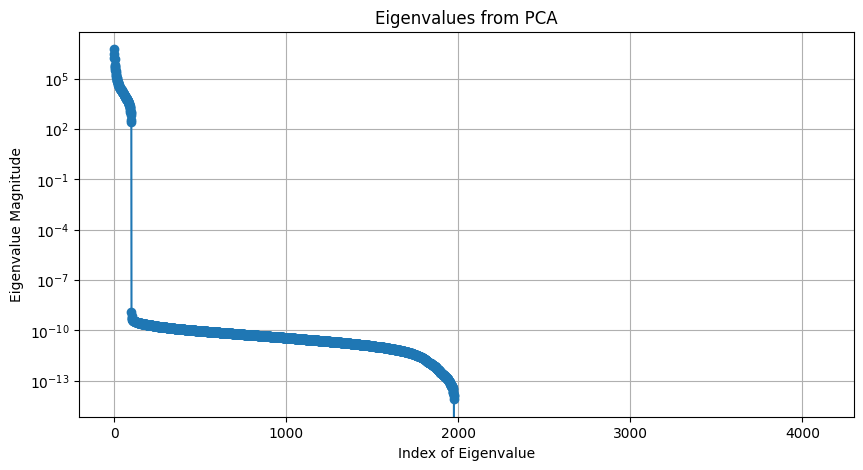

Retained eigenvalues: [5634008.9304147  2886260.72422839 1779790.26690838 1396128.16570941
  620869.65207909  528768.02795493  488364.40845305  425110.0459385
  311877.80348426  268966.20701274  207025.34165381  165250.14144716
  156633.76105056  131092.41934728  112149.74599212  104235.69203963
   87692.30970962   83921.45796134   72712.3767251    70143.0667412
   63686.07007052   62102.61840658]
Number of components to retain: 22


In [ ]:
def perform_pca(data, num_components=10):
    # Step 1: Compute the covariance matrix R
    covariance_matrix = np.dot(data.T, data) / data.shape[0]

    # Step 2: Eigenvalue decomposition of R
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # eigenvectors = U, eigenvalues are diagonal of Σ, R is already defined as covariance matrix

    # Step 3: Sort eigenvalues and eigenvectors  in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
     #U - Matrix of eigenvectors
    eigenvectors = eigenvectors[:, sorted_indices]


    # Σ - Diagonal matrix of eigenvalues
    #Sigma = np.diag(sorted_eigenvalues)

    # Verification of the decomposition R = UΣU^T
    #reconstructed_R = np.dot(U, np.dot(Sigma, U.T))

    # Step 4: Select top 'num_components' eigenvectors
    principal_components = eigenvectors[:, :num_components]

    # Step 5: Transform data
    transformed_data = np.dot(data, principal_components)

    return covariance_matrix, eigenvalues, transformed_data, principal_components, eigenvalues[:num_components]

# Perform PCA on your centralized images
# Example usage
data = centralized_images  # Replace with your actual data
covariance_matrix, eigenvalues, transformed_data, principal_components, top_eigenvalues = perform_pca(centralized_images, num_components=20)

#print("Covariance Matrix R:", covariance_matrix)
#print("Transformed data shape:", transformed_data.shape)
#print("Top eigenvalues:", top_eigenvalues)


# Plotting the eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(eigenvalues, marker='o')
plt.title('Eigenvalues from PCA')
plt.xlabel('Index of Eigenvalue')
plt.ylabel('Eigenvalue Magnitude')
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.show()

# Decide on a threshold for eigenvalues
# Example: retain eigenvalues that are at least 1% of the maximum eigenvalue
threshold = 0.01 * eigenvalues.max()
retained_eigenvalues = eigenvalues[eigenvalues > threshold]
print("Covariance Matrix R:", covariance_matrix)
print("Retained eigenvalues:", retained_eigenvalues)
print("Number of components to retain:", len(retained_eigenvalues))


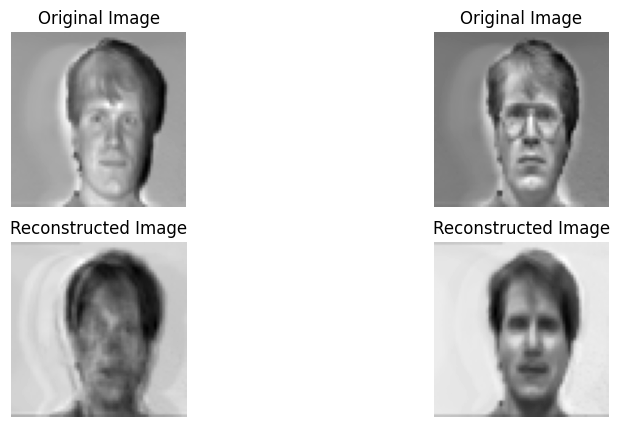

In [ ]:
def reconstruct_images(data, eigenvectors, num_components):
    # Step 1: Select the top 'num_components' eigenvectors
    principal_components = eigenvectors[:, :num_components]

    # Step 2: Project the zero-mean data onto these principal components
    projected_data = np.dot(data, principal_components)

    # Step 3: Reconstruct the data from the projected data
    reconstructed_data = np.dot(projected_data, principal_components.T)

    return reconstructed_data

# Assuming 'centralized_images', 'principal_components' and 'eigenvalues' from previous PCA
num_components_to_keep = 20  # Number of principal components to keep
reconstructed_images = reconstruct_images(centralized_images, principal_components, num_components_to_keep)

# Add the mean back to each reconstructed image (assuming 'mean_image' is available)
reconstructed_images += mean_image

# Display a couple of original and reconstructed images
def display_images(original_images, reconstructed_images, num_images=2):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(64, 64), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Display reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i].reshape(64, 64), cmap='gray')
        plt.title('Reconstructed Image')
        plt.axis('off')

    plt.show()

# Display images
display_images(centralized_images, reconstructed_images)

In [ ]:
def compute_mse(original_data, reconstructed_data):
    # Number of images
    n_images = original_data.shape[0]

    # Compute MSE for each image
    mse_values = np.mean((original_data - reconstructed_data) ** 2, axis=1)

    # Average MSE across all images
    average_mse = np.mean(mse_values)

    return mse_values, average_mse

# Assuming 'centralized_images' is the zero-mean version of your original data
# Assuming 'reconstructed_images' are the PCA reconstructed images after adding back the mean
original_images = centralized_images + mean_image  # Add the mean back to the original zero-mean images
reconstructed_images += mean_image  # Ensure the mean is added back to the reconstructed images if not already done

# Compute MSE
individual_mse, average_mse = compute_mse(original_images, reconstructed_images)

print("Average Mean Squared Error:", average_mse)
print("Individual Mean Squared Errors:", individual_mse)

Average Mean Squared Error: 36279.493380454434
Individual Mean Squared Errors: [36606.25139088 36134.24109976 36146.42039302 36681.69210794
 36247.65766612 36177.91704091 36804.98304627 36341.04758822
 36088.29054635 36278.12714345 36026.96168993 36491.85088853
 36293.80021811 36259.38233123 36035.58509082 36035.58509082
 36240.4069586  36024.34399398 36009.79504822 36825.31365399
 35989.98174302 36295.70805224 36732.82090272 36064.96849916
 36256.10871642 36137.67840945 36137.67840945 36099.02046134
 36308.97971399 36076.50457783 36132.28829843 36593.26481681
 36109.48718092 36186.21914823 36324.14473486 36613.96225626
 36090.44390376 36443.38522294 36264.84868226 36223.44871761
 36073.8926645  36118.55866662 36264.84868226 36170.000282
 36089.12958854 36119.74930305 36076.88735732 36055.93449253
 36062.9096493  36577.29395544 36143.04897235 36150.1889462
 36175.89403512 36037.85849478 36400.13691216 36121.8169881
 36110.4648382  36301.07034068 36100.36710953 36485.84669124
 36100.367

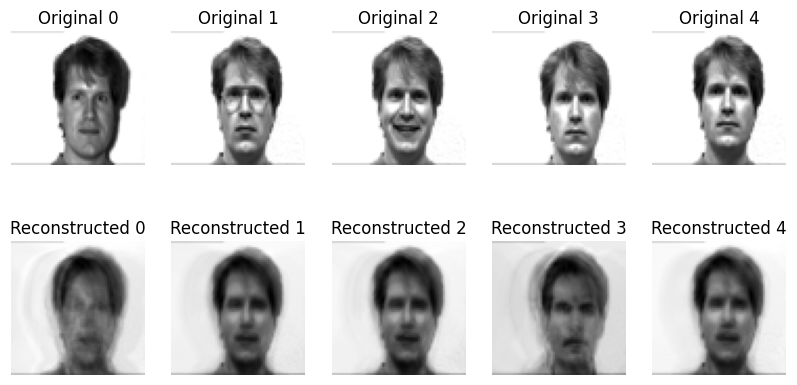

In [ ]:
def plot_comparison(original_images, reconstructed_images, indices):
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        # Original Image
        plt.subplot(2, len(indices), i + 1)
        plt.imshow(original_images[index].reshape(64, 64), cmap='gray')
        plt.title(f'Original {index}')
        plt.axis('off')

        # Reconstructed Image
        plt.subplot(2, len(indices), len(indices) + i + 1)
        plt.imshow(reconstructed_images[index].reshape(64, 64), cmap='gray')
        plt.title(f'Reconstructed {index}')
        plt.axis('off')
    plt.show()

# Example usage: Plot comparisons for the first 5 images
plot_comparison(original_images, reconstructed_images, indices=[0, 1, 2, 3, 4])


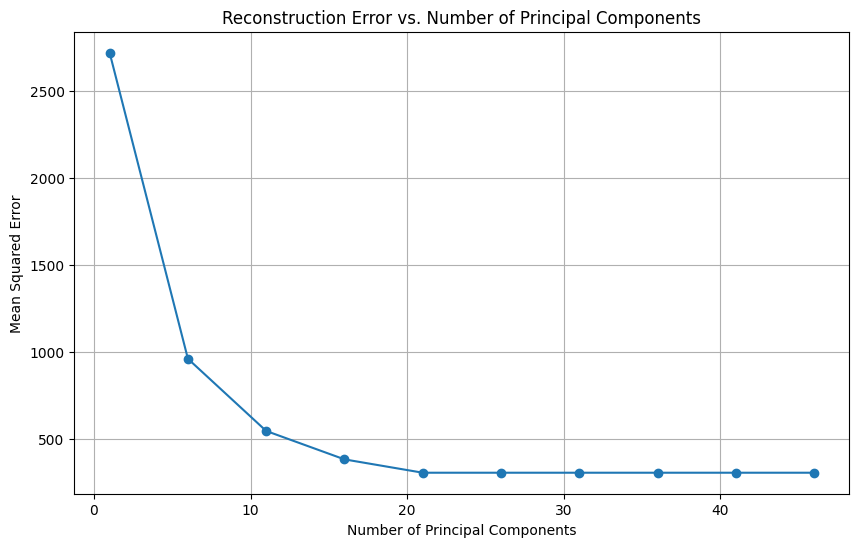

In [ ]:
def reconstruct_images(data, eigenvectors, num_components):
    principal_components = eigenvectors[:, :num_components]
    projected_data = np.dot(data, principal_components)
    reconstructed_data = np.dot(projected_data, principal_components.T)
    return reconstructed_data

def compute_mse(original_data, reconstructed_data):
    return np.mean((original_data - reconstructed_data) ** 2)

# Prepare a range of component numbers to test
component_range = range(1, 51, 5)  # For example, 1 to 50 components, step by 5

mse_scores = []

for num_components in component_range:
    reconstructed_images = reconstruct_images(centralized_images, principal_components, num_components)
    reconstructed_images += mean_image  # Add the mean back to get the original scale
    mse = compute_mse(original_images, reconstructed_images)
    mse_scores.append(mse)

# Plotting MSE scores against the number of components used
plt.figure(figsize=(10, 6))
plt.plot(component_range, mse_scores, marker='o', linestyle='-')
plt.title('Reconstruction Error vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


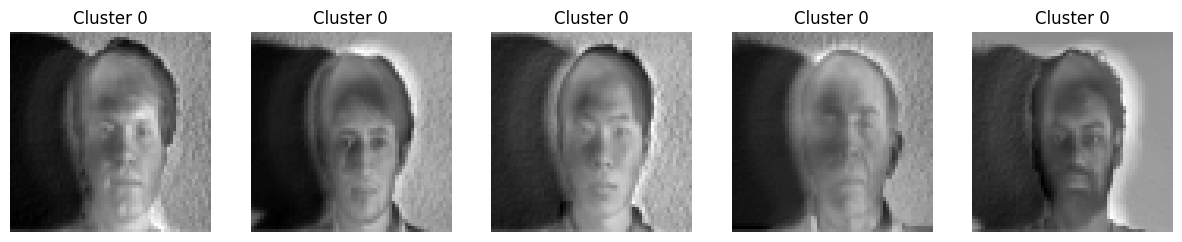

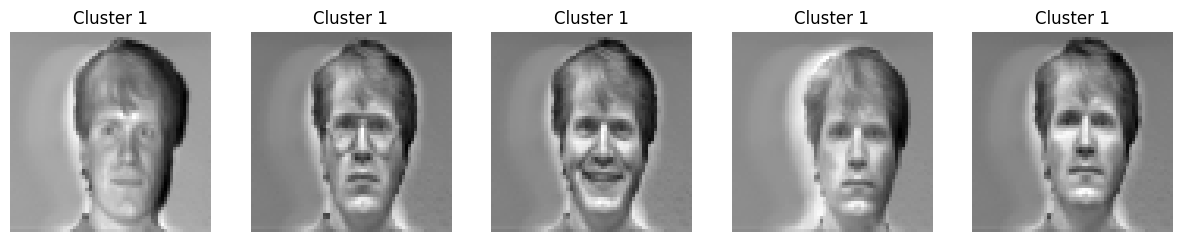

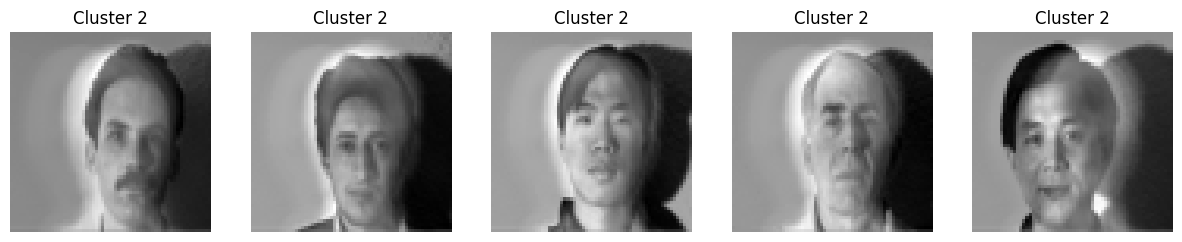

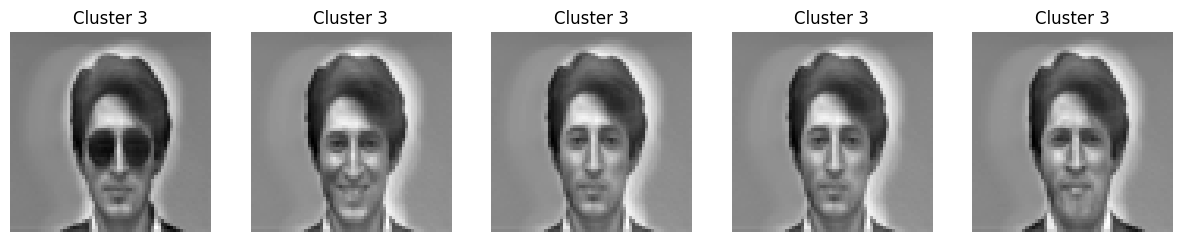

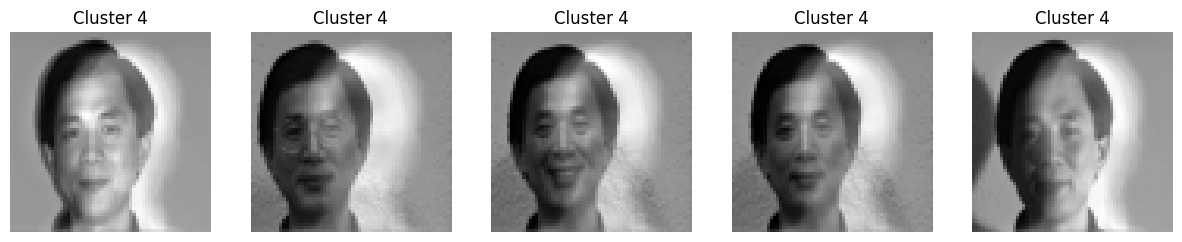

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Assuming 'centralized_images' is your data ready for PCA
# Number of principal components to use
n_components = 20

# Step 1: Perform PCA
pca = PCA(n_components=n_components)
pca_transformed_data = pca.fit_transform(centralized_images)

# Step 2: Apply K-means clustering
n_clusters = 5  # Adjust the number of clusters based on your data and needs
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(pca_transformed_data)

# Step 3: Analyze Clusters
# Optionally, visualize the centroids or cluster a few images
def display_cluster_images(images, labels, cluster_number, num_images=5):
    filter_labels = labels == cluster_number
    cluster_images = images[filter_labels][:num_images]

    plt.figure(figsize=(15, 3))
    for i, image in enumerate(cluster_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.reshape(64, 64), cmap='gray')
        plt.title(f'Cluster {cluster_number}')
        plt.axis('off')
    plt.show()

# Display images from each cluster
for i in range(n_clusters):
    display_cluster_images(centralized_images, clusters, i)